(c) 2023 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [1]:
# Load project package
@load_pkg Antibiotic

import Revise
# Import project package
import Antibiotic

# Import package to handle DataFrames
import DataFrames as DF
import CSV
import XLSX

# Import library to list files
import Glob

# Import packages to work with data
import StructArrays
import DataFrames as DF

# Load CairoMakie for plotting
using CairoMakie
import ColorSchemes
# Activate backend
CairoMakie.activate!()

# Set PBoC Plotting style
Antibiotic.viz.pboc_makie!()

# Data Wrangling for Iwasawa et al., 2020 PLoS Comp. Bio.

In this notebook we will transform the raw data that Iwasawa et al. gave us to a
tidy format we can work with.

The first thing we need to do is to list all of the files to be read. These are
the `OD620` measurements from the plate reader and are sorted by day.

In [2]:
# List all OD files
files_od = Glob.glob(
    "$(git_root())/data/Iwasawa_2022/od_raw_data/OD_data/day*/"[2:end] *
    "reshaped_od/*",
    "/"
)

1620-element Vector{String}:
 "/Users/mrazo/git/antibiotic_lan" ⋯ 52 bytes ⋯ "shaped_od/OD_day1_plate10_1.csv"
 "/Users/mrazo/git/antibiotic_lan" ⋯ 52 bytes ⋯ "shaped_od/OD_day1_plate10_2.csv"
 "/Users/mrazo/git/antibiotic_lan" ⋯ 52 bytes ⋯ "shaped_od/OD_day1_plate11_1.csv"
 "/Users/mrazo/git/antibiotic_lan" ⋯ 52 bytes ⋯ "shaped_od/OD_day1_plate11_2.csv"
 "/Users/mrazo/git/antibiotic_lan" ⋯ 52 bytes ⋯ "shaped_od/OD_day1_plate12_1.csv"
 "/Users/mrazo/git/antibiotic_lan" ⋯ 52 bytes ⋯ "shaped_od/OD_day1_plate12_2.csv"
 "/Users/mrazo/git/antibiotic_lan" ⋯ 52 bytes ⋯ "shaped_od/OD_day1_plate13_1.csv"
 "/Users/mrazo/git/antibiotic_lan" ⋯ 52 bytes ⋯ "shaped_od/OD_day1_plate13_2.csv"
 "/Users/mrazo/git/antibiotic_lan" ⋯ 52 bytes ⋯ "shaped_od/OD_day1_plate14_1.csv"
 "/Users/mrazo/git/antibiotic_lan" ⋯ 52 bytes ⋯ "shaped_od/OD_day1_plate14_2.csv"
 ⋮
 "/Users/mrazo/git/antibiotic_lan" ⋯ 51 bytes ⋯ "eshaped_od/OD_day9_plate5_2.csv"
 "/Users/mrazo/git/antibiotic_lan" ⋯ 51 bytes ⋯ "eshaped_od/OD_day

There are 1620 raw files. According to the authors:
> File names are defined as `OD_dayN_plateX_Y.csv` where `strain_num=2×(X-1)+Y`
> and the evolution environment for each `strain_num` is described in
> `./strain_num_matching.xlsx`

Let's load this `strain_num_matching.xlsx` file.

In [3]:
# Load file containing strain number description
strain_num_matching = DF.DataFrame(
    XLSX.readtable(
        "$(git_root())/data/Iwasawa_2022/od_raw_data/strain_num_matching.xlsx",
        "Sheet1"
    )
)

first(strain_num_matching, 5)

Row,strain_num,strain_env
,Any,Any
1,1,Parent in TET
2,2,Parent in TET
3,3,Parent in TET
4,4,Parent in TET
5,5,KME1 in TET


Furthermore, the authors describe the content of each of these CSV files as:

> `OD_dayN_plateX_Y.csv` contains the OD data for a certain strain for day *N*
> as a 8 $\times$ 24 matrix. The eight rows represent the eight drugs (TET, KM,
> NFLX, SS, PLM, NQO, SDC, MMC), and the 24 columns represent the 24 wells in
> the 384-well plate which were used to make a drug concentration gradient. 

Let's load one of these tables.

In [4]:
# Load example table
df_od_ex = CSV.read(files_od[1], DF.DataFrame)

# Rename antibiotic column
DF.rename!(df_od_ex, "Column1" => :antibiotic)
# Rename column names
DF.rename!(df_od_ex, Dict(zip(string.(1:24), "col" .* string.(1:24))))

Row,antibiotic,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19,col20,col21,col22,col23,col24
,String7,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,TET,0.0464,0.0807,0.0903,0.1083,0.115,0.1434,0.1632,0.1784,0.1823,0.1826,0.1745,0.1805,0.1771,0.1688,0.1594,0.1536,0.1527,0.1504,0.1585,0.1614,0.1607,0.1645,0.1697,0.1828
2,KM,0.0432,0.0426,0.0501,0.0417,0.0411,0.0396,0.0368,0.0358,0.0355,0.0352,0.0361,0.0372,0.0601,0.1429,0.1549,0.1611,0.1562,0.1601,0.1601,0.1695,0.1662,0.1636,0.1681,0.1771
3,NFLX,0.0414,0.0541,0.0564,0.0557,0.055,0.0537,0.053,0.0566,0.1439,0.1692,0.1669,0.1696,0.1739,0.1745,0.1694,0.1624,0.16,0.1582,0.1566,0.1552,0.1571,0.1529,0.1524,0.1649
4,SS,0.0415,0.0436,0.0464,0.0447,0.0413,0.0401,0.0372,0.0363,0.0361,0.036,0.0359,0.0752,0.0395,0.1355,0.1383,0.1365,0.1413,0.1411,0.1483,0.1729,0.1554,0.1601,0.1637,0.1835
5,PLM,0.0427,0.0472,0.0473,0.0456,0.0432,0.0424,0.0395,0.0402,0.0393,0.0428,0.0604,0.1918,0.1835,0.1889,0.1816,0.1763,0.1741,0.1728,0.1757,0.1688,0.1647,0.16,0.1571,0.1688
6,NQO,0.0417,0.0431,0.0431,0.0423,0.0422,0.0407,0.0375,0.0377,0.0375,0.0479,0.1479,0.1801,0.1624,0.161,0.1562,0.1564,0.1601,0.1563,0.1611,0.1651,0.1658,0.1702,0.1647,0.1758
7,SDC,0.0445,0.0458,0.0472,0.045,0.0432,0.0409,0.0378,0.0376,0.0371,0.0371,0.0364,0.0377,0.0362,0.0368,0.0364,0.0372,0.0403,0.1031,0.1874,0.1755,0.1686,0.1714,0.1736,0.1821
8,MMC,0.0452,0.0535,0.0497,0.059,0.1859,0.2033,0.1627,0.1669,0.1624,0.1616,0.1652,0.1743,0.1913,0.1807,0.1756,0.1723,0.1683,0.1677,0.1705,0.1692,0.1704,0.1631,0.1785,0.1875


Each entry in this table is the final OD measurement as determined by their
plate reader for each of the different concentrations of the drugs. To know what
the concentration on each well was, the authors provide a series of tables with
the designs of each plate. These design specifications are stored in the
`od_raw_data/conc_data/` directory. Let's load all 8 plate designs.

In [5]:
# List files with plate designs
files_conc = Glob.glob(
    "$(git_root())/data/Iwasawa_2022/od_raw_data/conc_data/Plate*.xlsx"[2:end],
    "/"
)

# Initialize dataframe where to store plate design
df_design = DF.DataFrame()

# Loop through files
for f in files_conc
    # Extract plate number from file name
    pnum = parse(
        Int64, replace(split(f, "/")[end], "Plate" => "", ".xlsx" => "")
    )
    # Read file into memory
    df = DF.DataFrame(XLSX.readtable(f, "Sheet1"))
    # Add plate number columnd
    df[!, "plate"] .= pnum
    # Append to global dataframe
    append!(df_design, df)
end # for

first(df_design, 9)

Row,StressName,StockConcentration_mg_per_ml,MaxConc_ug_per_ml,step_size,plate
,Any,Any,Any,Any,Int64
1,TET,0.05,4.73029,0.25,1
2,KM,1.5,141.909,0.25,1
3,NFLX,0.005,0.473029,0.25,1
4,SS,50,3977.48,0.5,1
5,PLM,1,79.5495,0.5,1
6,NQO,0.2,15.9099,0.5,1
7,SDC,2,159.099,0.5,1
8,MMC,0.145,11.5347,0.5,1
9,TET,0.02,1.89212,0.25,2


The way the concentrations are built from this is as follows: 
- The first column of each plate **is the blank** where no strains grew.
- The second column of each strain contains the **maximum** antibiotic
  concentration as dictated by the column `MaxConc_ug_per_ml`.
- Each successive well (except the last one) is diluted with respect to the
  previous well by a factor of `1 / 2^step_size`. This is because the
  `step_size` column defines the exponent for how much the concentration
  increases from right to left.
- The last well has no antibiotic.

Given this information, we should be able to build an 8 $\times$ 24 matrix with
the drug concentration for each plate. Let's do it for plate 1 as an example.

In [6]:
# Extract plate design
df_plate = df_design[df_design.plate.==1, :]
# Generate a DataFrame with the same structure as the OD examples
df_conc_ex = similar(df_od_ex)
# Set first column to be the drug name
df_conc_ex[:, :antibiotic] = df_plate[:, :StressName]
# Define the zero-concentration columns
df_conc_ex[:, [2, 25]] .= 0.0
# Loop through the rest of the columns
for (i, col) in enumerate(3:24)
    # Compute concentration
    df_conc_ex[:, col] = df_plate[:, :MaxConc_ug_per_ml] ./
                         2.0 .^ ((i - 1) .* df_plate[:, :step_size])
end # for

df_conc_ex

Row,antibiotic,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19,col20,col21,col22,col23,col24
,String7,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,TET,0.0,4.73029,3.97769,3.34482,2.81265,2.36515,1.98884,1.67241,1.40632,1.18257,0.994422,0.836206,0.703162,0.591287,0.497211,0.418103,0.351581,0.295643,0.248605,0.209051,0.175791,0.147822,0.124303,0.0
2,KM,0.0,141.909,119.331,100.345,84.3795,70.9544,59.6653,50.1723,42.1897,35.4772,29.8327,25.0862,21.0949,17.7386,14.9163,12.5431,10.5474,8.8693,7.45816,6.27154,5.27372,4.43465,3.72908,0.0
3,NFLX,0.0,0.473029,0.397769,0.334482,0.281265,0.236515,0.198884,0.167241,0.140632,0.118257,0.0994422,0.0836206,0.0703162,0.0591287,0.0497211,0.0418103,0.0351581,0.0295643,0.0248605,0.0209051,0.0175791,0.0147822,0.0124303,0.0
4,SS,0.0,3977.48,2812.5,1988.74,1406.25,994.369,703.125,497.184,351.562,248.592,175.781,124.296,87.8906,62.1481,43.9453,31.074,21.9727,15.537,10.9863,7.76851,5.49316,3.88425,2.74658,0.0
5,PLM,0.0,79.5495,56.25,39.7748,28.125,19.8874,14.0625,9.94369,7.03125,4.97184,3.51562,2.48592,1.75781,1.24296,0.878906,0.621481,0.439453,0.31074,0.219727,0.15537,0.109863,0.0776851,0.0549316,0.0
6,NQO,0.0,15.9099,11.25,7.95495,5.625,3.97748,2.8125,1.98874,1.40625,0.994369,0.703125,0.497184,0.351562,0.248592,0.175781,0.124296,0.0878906,0.0621481,0.0439453,0.031074,0.0219727,0.015537,0.0109863,0.0
7,SDC,0.0,159.099,112.5,79.5495,56.25,39.7748,28.125,19.8874,14.0625,9.94369,7.03125,4.97184,3.51562,2.48592,1.75781,1.24296,0.878906,0.621481,0.439453,0.31074,0.219727,0.15537,0.109863,0.0
8,MMC,0.0,11.5347,8.15625,5.76734,4.07812,2.88367,2.03906,1.44183,1.01953,0.720917,0.509766,0.360459,0.254883,0.180229,0.127441,0.0901147,0.0637207,0.0450573,0.0318604,0.0225287,0.0159302,0.0112643,0.00796509,0.0


To make sure that this is correct, let's plot the OD of our example plate as a
function of the concentration we computed.

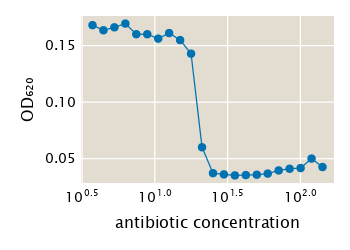

In [7]:
# Initialize figure
fig = Figure(resolution=(350, 250))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="antibiotic concentration",
    ylabel="OD₆₂₀",
    xscale=log10
)

# Add line for antibiotic
scatterlines!(
    ax, Vector(df_conc_ex[2, 3:end-1]), Vector(df_od_ex[2, 3:end-1]),
)

fig

This is exactly the behavior we expect. Therefore, our concentration matrix is
correct. Let's build a DataFrame with all the plate designs concentrations.

In [8]:
# Initialize DataFrame where to store all plate desings
df_plates = DF.DataFrame()

# Loop through unique plate designs
for plate in unique(df_design.plate)
    # Extract plate design
    df_plate = df_design[df_design.plate.==plate, :]
    # Generate a DataFrame with the same structure as the OD examples
    df_conc = similar(df_od_ex)
    # Set first column to be the drug name
    df_conc[:, :antibiotic] = df_plate[:, :StressName]
    # Define the zero-concentration columns
    df_conc[:, [2, 25]] .= 0.0
    # Loop through the rest of the columns
    for (i, col) in enumerate(3:24)
        # Compute concentration
        df_conc[:, col] = df_plate[:, :MaxConc_ug_per_ml] ./
                          2.0 .^ ((i - 1) .* df_plate[:, :step_size])
    end # for
    # Add plate columns
    df_conc[!, :design] .= plate
    # Append dataframe
    append!(df_plates, df_conc)
end # for

first(df_plates, 5)

Row,antibiotic,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19,col20,col21,col22,col23,col24,design
,String7,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64
1,TET,0.0,4.73029,3.97769,3.34482,2.81265,2.36515,1.98884,1.67241,1.40632,1.18257,0.994422,0.836206,0.703162,0.591287,0.497211,0.418103,0.351581,0.295643,0.248605,0.209051,0.175791,0.147822,0.124303,0.0,1
2,KM,0.0,141.909,119.331,100.345,84.3795,70.9544,59.6653,50.1723,42.1897,35.4772,29.8327,25.0862,21.0949,17.7386,14.9163,12.5431,10.5474,8.8693,7.45816,6.27154,5.27372,4.43465,3.72908,0.0,1
3,NFLX,0.0,0.473029,0.397769,0.334482,0.281265,0.236515,0.198884,0.167241,0.140632,0.118257,0.0994422,0.0836206,0.0703162,0.0591287,0.0497211,0.0418103,0.0351581,0.0295643,0.0248605,0.0209051,0.0175791,0.0147822,0.0124303,0.0,1
4,SS,0.0,3977.48,2812.5,1988.74,1406.25,994.369,703.125,497.184,351.562,248.592,175.781,124.296,87.8906,62.1481,43.9453,31.074,21.9727,15.537,10.9863,7.76851,5.49316,3.88425,2.74658,0.0,1
5,PLM,0.0,79.5495,56.25,39.7748,28.125,19.8874,14.0625,9.94369,7.03125,4.97184,3.51562,2.48592,1.75781,1.24296,0.878906,0.621481,0.439453,0.31074,0.219727,0.15537,0.109863,0.0776851,0.0549316,0.0,1


These are the eight plate designs that they used in this experiment. But to
match it to which design was used on each day, the authors say:
> `PlateX.xlsx: X = 1,...,8` corresponds to the numbers in
> `PlateType_201907_matching_30plates_TimeSeries.xlsx`.

Furthermore, they describe this file as:
> `PlateType_201907_matching_30plates_TimeSeries.xlsx`: This xlsx file includes
> the information of which plate in `./conc_data` was used in `dayN`. plate_num
> in the leftmost column corresponds to `X` in
> `./reshaped_od/OD_dayN_plateX_Y.csv`. This xlsx file was needed to track the
> changes of the plate designs along the drug resistance evolution of the
> strains.

Let's load this file.

In [9]:
# Load file to match plate number to plate design
plate_num = DF.DataFrame(
    XLSX.readtable(
        "$(git_root())/data/Iwasawa_2022/od_raw_data/" *
        "PlateType_201907_matching_30plates_TimeSeries.xlsx",
        "Sheet1"
    )
)

first(plate_num, 5)

Row,plate_num,day1,day2,day3,day4,day5,day6,day7,day8,day9,day10,day11,day12,day13,day14,day15,day16,day17,day18,day19,day20,day21,day22,day23,day24,day25,day26,day27,day28
,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any
1,1,1,1,1,1,1,1,1,1,1,1,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
2,2,1,1,1,1,1,1,1,1,1,1,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,8,8,8,8,8,8,8,8
4,4,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,8,8,8,8,8,8,8,8
5,5,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,8,8,8,8,8,8,8,8


We now have all of the pieces in place to turn the data into a tidy dataframe.
The only missing piece is joining the values of the concentrations with the OD.
Let's check how to do this with our example plate.

In [10]:
# Pivot OD dataframe into tidy format
df_od_tidy = DF.stack(df_od_ex, DF.Not(:antibiotic))
# Rename columns
DF.rename!(df_od_tidy, Dict(:variable => :col, :value => :OD))

# Pivot plate 1 design into tidy format
df_conc_tidy = DF.stack(
    df_plates[df_plates.design.==1, :], DF.Not([:antibiotic, :design])
)
# Rename columns
DF.rename!(df_conc_tidy, Dict(:variable => :col, :value => :concentration_ugmL))

# Join dataframes by common columns
df_join = DF.innerjoin(df_od_tidy, df_conc_tidy, on=[:antibiotic, :col])

first(df_join, 10)

Row,antibiotic,col,OD,design,concentration_ugmL
,String7,String,Float64,Int64,Float64
1,TET,col1,0.0464,1,0.0
2,KM,col1,0.0432,1,0.0
3,NFLX,col1,0.0414,1,0.0
4,SS,col1,0.0415,1,0.0
5,PLM,col1,0.0427,1,0.0
6,NQO,col1,0.0417,1,0.0
7,SDC,col1,0.0445,1,0.0
8,MMC,col1,0.0452,1,0.0
9,TET,col2,0.0807,1,4.73029


Perfect! Now we have all of the necessary tools and pieces to build the tidy
dataframe. Let's read through all files and build it.

In [11]:
# Initialize dataframe
df_tidy = DF.DataFrame()

# Loop through files
for f in files_od
    # Extract day
    day = parse(Int64, replace(split(split(f, "/")[end], "_")[2], "day" => ""))
    # Extract plate number
    x = parse(
        Int64, replace(split(split(f, "/")[end], "_")[3], "plate" => "")
    )
    # Extract final number
    y = parse(Int64, replace(split(f, "_")[end], ".csv" => ""))
    # Compute strain number
    strain_num = 2 * (x - 1) + y

    # Extract environment from strain_num_matching
    env = first(
        strain_num_matching[
            strain_num_matching.strain_num.==strain_num, :strain_env
        ]
    )
    # Replace spaces with underscore
    env = replace(env, " " => "_")

    # Extract plate design from
    # PlateType_201907_matching_30plates_TimeSeries.xlsx
    design = first(plate_num[(plate_num.plate_num.==x), "day$(day)"])

    # Load table
    df_od = CSV.read(f, DF.DataFrame)
    # Rename antibiotic column
    DF.rename!(df_od, "Column1" => :antibiotic)
    # Rename column names
    DF.rename!(df_od, Dict(zip(string.(1:24), "col" .* string.(1:24))))

    # Pivot OD dataframe into tidy format
    df_od_tidy = DF.stack(df_od, DF.Not(:antibiotic))
    # Rename columns
    DF.rename!(df_od_tidy, Dict(:variable => :col, :value => :OD))

    # Pivot plate 1 design into tidy format
    df_conc_tidy = DF.stack(
        df_plates[df_plates.design.==design, :], DF.Not([:antibiotic, :design])
    )
    # Rename columns
    DF.rename!(
        df_conc_tidy, Dict(:variable => :col, :value => :concentration_ugmL)
    )

    # Join dataframes by common columns
    df_join = DF.innerjoin(df_od_tidy, df_conc_tidy, on=[:antibiotic, :col])

    # # Add day information
    df_join[!, :day] .= day
    # # Add strain number
    df_join[!, :strain_num] .= strain_num
    # Add corresponding strain environment
    df_join[!, :env] .= env
    # Add corresponding plate design
    df_join[!, :plate] .= x
    # Add column indicating if it is a blank or not
    df_join[!, :blank] = df_join.col .== "col1"

    # Append to final result
    append!(df_tidy, df_join)

end # for

first(df_tidy, 5)

Row,antibiotic,col,OD,design,concentration_ugmL,day,strain_num,env,plate,blank
,String7,String,Float64,Int64,Float64,Int64,Int64,String,Int64,Bool
1,TET,col1,0.0464,3,0.0,1,19,TETE4_in_KM,10,true
2,KM,col1,0.0432,3,0.0,1,19,TETE4_in_KM,10,true
3,NFLX,col1,0.0414,3,0.0,1,19,TETE4_in_KM,10,true
4,SS,col1,0.0415,3,0.0,1,19,TETE4_in_KM,10,true
5,PLM,col1,0.0427,3,0.0,1,19,TETE4_in_KM,10,true


To double-check that the structure of the table makes sense, let's plot the time
series for one example to see if the sequence agrees with the expectation.

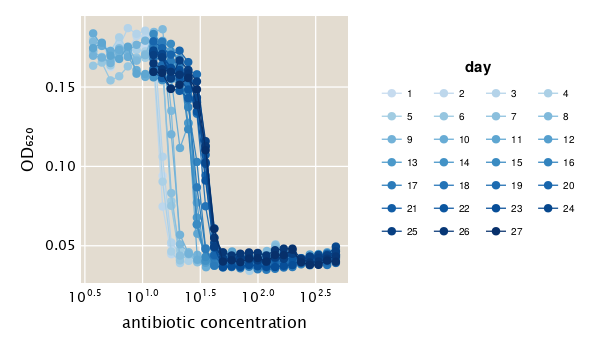

In [12]:
# Define data to use
data = df_tidy[(df_tidy.antibiotic.=="KM").&(df_tidy.env.=="Parent_in_KM").&(df_tidy.strain_num.==13).&.!(df_tidy.blank).&(df_tidy.concentration_ugmL.>0), :]
# Remove blank measurement
# Group data by day
df_group = DF.groupby(data, :day)

# Initialize figure
fig = Figure(resolution=(600, 350))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="antibiotic concentration",
    ylabel="OD₆₂₀",
    xscale=log10
)

# Define colors for plot
colors = get(ColorSchemes.Blues_9, LinRange(0.25, 1, length(df_group)))

# Loop through days
for (i, d) in enumerate(df_group)
    # Sort data by concentration
    DF.sort!(d, :concentration_ugmL)
    # Plot scatter line
    scatterlines!(
        ax, d.concentration_ugmL, d.OD, color=colors[i], label="$(first(d.day))"
    )
end # for

# Add legend to plot
fig[1, 2] = Legend(
    fig, ax, "day", framevisible=false, nbanks=4, labelsize=10
)

fig

We can see that, as expected, the curves shift to higher concentrations as the
number of days pass by.

Thus, we can confidently say that we built the right tidy DataFrame. Let's write
it down as a `.csv` file.

In [13]:
first(df_tidy, 5)

Row,antibiotic,col,OD,design,concentration_ugmL,day,strain_num,env,plate,blank
,String7,String,Float64,Int64,Float64,Int64,Int64,String,Int64,Bool
1,TET,col1,0.0464,3,0.0,1,19,TETE4_in_KM,10,true
2,KM,col1,0.0432,3,0.0,1,19,TETE4_in_KM,10,true
3,NFLX,col1,0.0414,3,0.0,1,19,TETE4_in_KM,10,true
4,SS,col1,0.0415,3,0.0,1,19,TETE4_in_KM,10,true
5,PLM,col1,0.0427,3,0.0,1,19,TETE4_in_KM,10,true


In [14]:
CSV.write("$(git_root())/data/Iwasawa_2022/iwasawa_tidy.csv", df_tidy)

"/Users/mrazo/git/antibiotic_landscape/data/Iwasawa_2022/iwasawa_tidy.csv"

# Formatting $IC_{50}$ concentrations

In principle, the main information we want to extract from the data we
manipulated above is the $IC_{50}$. Later on, we will define a proper Bayesian
inference pipeline to infer these values. But for now, we can use the
pre-processed data provided by the authors. As part of their supplementary
information, they provide the raw data utilized to generate all figures in the
paper. In particular, Fig. 1(C) contains these $IC_{50}$ values (no error bars)
that we can use for exploratory data analysis. Let's load this data.

In [24]:
# Load Fig 1C data
df_ic50 = DF.DataFrame(
    XLSX.readtable(
        "$(git_root())/data/Iwasawa_2022/supplementary_data.xlsx",
        "Fig1C"
    )
)

first(df_ic50, 5)

Row,strain,drug,day1,day2,day3,day4,day5,day6,day7,day8,day9,day10,day11,day12,day13,day14,day15,day16,day17,day18,day19,day20,day21,day22,day23,day24,day25,day26,day27
,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any
1,KME5 in TET1,TET,-1.66344,-1.79873,-1.57461,-0.719812,-0.424413,-0.204741,-0.20007,0.0915818,0.11815,-0.245541,-0.500649,-0.17641,0.222039,0.662359,0.39194,0.399584,0.391879,0.282816,0.440313,0.638396,0.424139,1.32902,1.9396,1.87274,1.89138,1.99109,1.98763
2,KME5 in TET1,KM,6.0454,6.45626,6.48829,6.51009,6.68396,6.61118,6.56009,6.66116,6.60634,6.58289,6.44135,6.56549,6.5631,6.40999,6.21144,6.14834,6.07657,6.12986,6.17119,6.21822,6.22656,6.16733,5.65765,5.31218,5.36847,5.32563,5.46773
3,KME5 in TET1,NFLX,-4.69443,-4.71081,-4.69919,-4.60659,-4.17957,-4.1333,-3.90161,-3.88874,-3.78354,-3.71686,-3.82934,-3.82645,-3.59551,-3.34154,-3.10012,-2.97372,-3.02214,-3.2392,-3.06951,-2.85727,-2.95837,-3.06672,-3.61785,-3.98616,-3.91427,-3.92507,-3.9162
4,KME5 in TET1,SS,5.37514,5.47275,5.48175,5.53383,5.61008,5.66522,5.57929,5.64381,5.62594,5.64673,5.46268,5.50685,5.75911,5.9822,5.94516,5.87516,5.92322,5.72562,5.70725,5.86714,5.77844,5.84773,6.09327,5.77572,5.78859,5.73097,5.74877
5,KME5 in TET1,PLM,5.61675,5.76577,5.81269,6.28226,6.31378,6.31378,6.31378,6.31378,6.30311,6.31378,5.74514,6.30442,6.31378,6.29497,6.30127,6.30744,6.30203,6.31378,6.31378,6.31378,6.31378,6.31378,4.55339,4.14055,4.28281,4.13924,4.28466


Let's transform this into a tidy dataframe.

In [25]:
# Define tidy dataframe
df_ic50_tidy = DF.stack(df_ic50, DF.Not([:strain, :drug]))

# Rename columns
DF.rename!(df_ic50_tidy, :variable => :dayname, :value => :log2ic50)

first(df_ic50_tidy, 5)

Row,strain,drug,dayname,log2ic50
,Any,Any,String,Any
1,KME5 in TET1,TET,day1,-1.66344
2,KME5 in TET1,KM,day1,6.0454
3,KME5 in TET1,NFLX,day1,-4.69443
4,KME5 in TET1,SS,day1,5.37514
5,KME5 in TET1,PLM,day1,5.61675


Let's parse the `day` column to have numerical values. Moreover, let's add a
linear value of the $IC_{50}$.

In [51]:
# Add numerical value to day
df_ic50_tidy[!, :day] = [
    parse(Int64, replace(x, "day" => "")) for x in df_ic50_tidy.dayname
]

df_ic50_tidy[!, :ic50_µgmL] = 2 .^ (df_ic50_tidy.log2ic50)

first(df_ic50_tidy, 5)

Row,strain,drug,dayname,log2ic50,day,ic50_μgmL
,Any,Any,String,Any,Int64,Float64
1,KME5 in TET1,TET,day1,-1.66344,1,0.315686
2,KME5 in TET1,KM,day1,6.0454,1,66.0461
3,KME5 in TET1,NFLX,day1,-4.69443,1,0.038622
4,KME5 in TET1,SS,day1,5.37514,1,41.5029
5,KME5 in TET1,PLM,day1,5.61675,1,49.0693


To make sure this is the correct data, let's reproduce one of the panels in Fig.
1C.

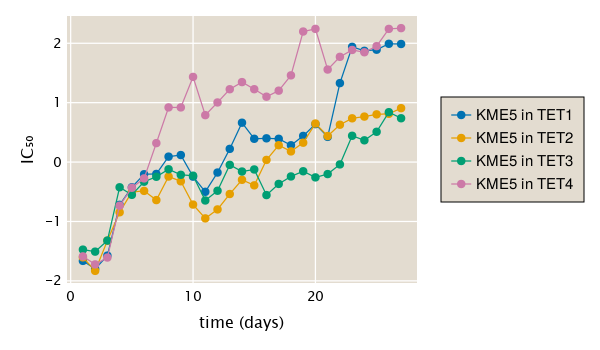

In [52]:
# Initialize figure
fig = Figure(resolution=(600, 350))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="time (days)",
    ylabel="IC₅₀",
)

# Select data to plot
data = df_ic50_tidy[
    occursin.("KME5 in TET", df_ic50_tidy.strain).&(df_ic50_tidy.drug.=="TET"),
    :]

# Group data
data_group = DF.groupby(data, :strain)
# Extract keys
data_keys = [x["strain"] for x in keys(data_group)]

# Loop through groups
for (i, d) in enumerate(data_group)
    # Plot trajectory
    scatterlines!(
        ax, collect(d.day), Float64.(collect(d.log2ic50)), label=data_keys[i]
    )
end # for

# Add legend
Legend(fig[1, 2], ax)

fig

This looks exactly as the first panel of Fig. 1C. So we have the right
dataframe. Let's export it.

In [53]:
CSV.write(
    "$(git_root())/data/Iwasawa_2022/iwasawa_ic50_tidy.csv",
    df_ic50_tidy[:, DF.Not(:dayname)]
)

"/Users/mrazo/git/antibiotic_landscape/data/Iwasawa_2022/iwasawa_ic50_tidy.csv"